In [1]:
# Librerías utilizadas por el script
import timm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fastai.vision.all import *
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [2]:
import torch

"""
!pip install -Uqq fastbook
!pip install nbdev
"""
import fastbook

fastbook.setup_book()
import fastai
import fastcore

print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

fastcore version 1.5.29 installed
fastai version 2.7.14 installed


In [3]:
torch.cuda.is_available()

True

In [4]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fasst.ai/t/plotting-metrics-after-learning/69937
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif ncols is None:
        ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [5]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im, title='Result',factor= 2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im es tribanda
    plt.imshow(im, cmap='jet')
  else:
    # im es monobanda
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([]) # eliminamos numeración
  plt.show()

# This function display the KeyPoints of an image
def showKP(im,kp,title):
    im_orig = im.copy()
    for curKey in kp:
            x=np.int(curKey.pt[0])
            y=np.int(curKey.pt[1])
            size = np.int(curKey.size)
            cv2.circle(im,(x,y),40,color=(255,0,0), thickness=4) 
    displayIm(im, title)  

In [6]:
df = pd.read_csv('trainSet.csv')

In [7]:
def label_func(fname):
    global df
    if (str(fname)[-4:] == ".bmp"):
        el = df.loc[df['image'] == str(fname)[:-4].split("/")[1]]
        return ((el['class'].values[0]))
    else:
        el = df.loc[df['image'] == str(fname).split("/")[1]]
        return ((el['class'].values[0]))

In [8]:
"""## Normalización

import os
import numpy as np
from PIL import Image

# Directorio donde se encuentran las imágenes
directorio_imagenes = "trainThumbnails"

# Lista para almacenar los valores de brillo promedio de las imágenes
im_colors = []

# Recorre todas las imágenes en el directorio
for filename in os.listdir(directorio_imagenes):
    ruta_completa = os.path.join(directorio_imagenes, filename)
    imagen = Image.open(ruta_completa)
    # Calcula el brillo promedio de la imagen (puedes adaptar esto según tus necesidades)
    media = np.mean(imagen)
    im_colors.append(media)

# Calcula la media y la desviación estándar de los valores de brillo
med_col= np.mean(im_colors)
desv_col = np.std(im_colors)

print(f"Media: {med_col:.2f}")
print(f"Desviación estándar: {desv_col:.2f}")"""

'## Normalización\n\nimport os\nimport numpy as np\nfrom PIL import Image\n\n# Directorio donde se encuentran las imágenes\ndirectorio_imagenes = "trainThumbnails"\n\n# Lista para almacenar los valores de brillo promedio de las imágenes\nim_colors = []\n\n# Recorre todas las imágenes en el directorio\nfor filename in os.listdir(directorio_imagenes):\n    ruta_completa = os.path.join(directorio_imagenes, filename)\n    imagen = Image.open(ruta_completa)\n    # Calcula el brillo promedio de la imagen (puedes adaptar esto según tus necesidades)\n    media = np.mean(imagen)\n    im_colors.append(media)\n\n# Calcula la media y la desviación estándar de los valores de brillo\nmed_col= np.mean(im_colors)\ndesv_col = np.std(im_colors)\n\nprint(f"Media: {med_col:.2f}")\nprint(f"Desviación estándar: {desv_col:.2f}")'

In [9]:
import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import cv2

# Directorio donde se encuentran las imágenes
directorio_imagenes = "trainThumbnails"

# Función para procesar una imagen y calcular los valores de brillo
def procesar_imagen(filename):
    ruta_completa = os.path.join(directorio_imagenes, filename)
    imagen = readIm(ruta_completa)
    # Calcula el brillo promedio de la imagen
    mean = [np.mean(imagen[:,:,0]), np.mean(imagen[:,:,1]), np.mean(imagen[:,:,2])]
    std = [np.std(imagen[:,:,0]), np.std(imagen[:,:,1]), np.std(imagen[:,:,2])]
    return mean, std

# Recorre todas las imágenes en el directorio de manera paralela
with ThreadPoolExecutor() as executor:
    futures = []
    for filename in os.listdir(directorio_imagenes):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            futures.append(executor.submit(procesar_imagen, filename))

# Obtiene los resultados
mean_values = []
std_values = []
for future in futures:
    mean, std = future.result()
    mean_values.append(mean)
    std_values.append(std)

avg = np.mean(mean_values, axis=0)
std = np.std(std_values, axis=0)


In [10]:
# División en 70% train y 30% validación
trainSet = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    splitter=RandomSplitter(valid_pct=0.3, seed=0),  # Establecida semilla 0
    get_y=label_func,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(356, method='squish')],  # Redimensionado
    batch_tfms=[Normalize.from_stats(avg,std), *aug_transforms()]
).dataloaders("trainThumbnails/", bs=16)

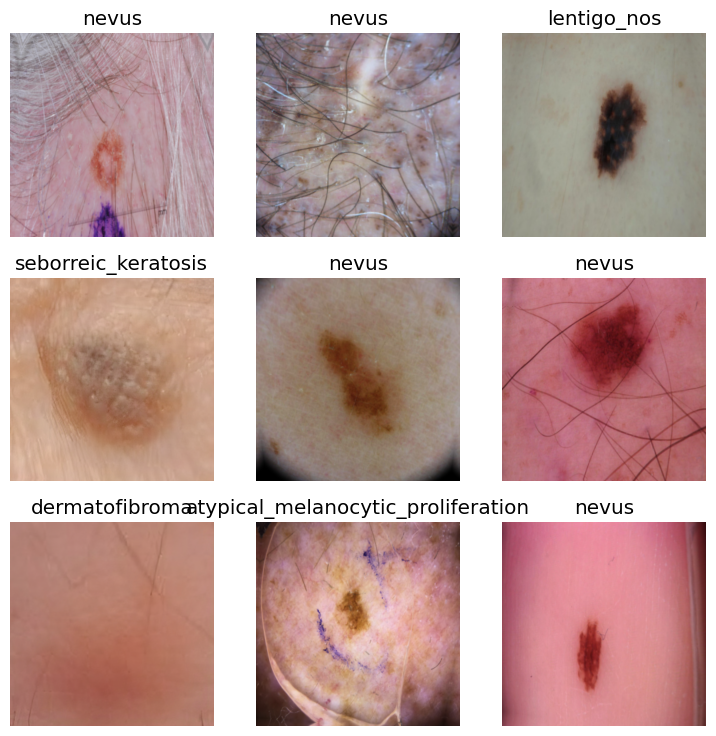

In [11]:
trainSet.show_batch()  # shows a batch of images

In [12]:
# Calcula la frecuencia de cada clase

class_frequencies = df["class"].value_counts()
class_weights = 1 / class_frequencies

print(class_weights)

class_weights = torch.cuda.FloatTensor(class_weights).cuda()

class
nevus                                 0.000047
seborreic_keratosis                   0.000148
basal_cell_carcinoma                  0.000177
melanoma                              0.000208
actinic_keratosis                     0.000303
wart                                  0.000323
melanocytic_nevus                     0.000351
epidermal_cyst                        0.000356
dermatofibroma                        0.000386
squamous_cell_carcinoma               0.000390
hemangioma                            0.000491
lentigo_nos                           0.001047
pigmented_benign_keratosis            0.001245
pyogenic_granuloma                    0.001718
intraepithelial_carcinoma             0.001815
neurofibroma                          0.002208
solar_lentigo                         0.002967
syringoma                             0.003774
blue_nevus                            0.004717
vascular_lesion                       0.004785
melanoma_metastasis                   0.004926
venous_

/tmp/ipykernel_201401/684520669.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights = torch.cuda.FloatTensor(class_weights).cuda()
/tmp/ipykernel_201401/684520669.py:8: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  class_weights = torch.cuda.FloatTensor(class_weights).cuda()


In [19]:
efnet_3_learner = vision_learner(trainSet, 'tf_efficientnet_lite3', loss_func=FocalLoss(), metrics=[accuracy, error_rate],pretrained=True)
efnet_3_learner.summary()

Sequential (Input shape: 16 x 3 x 356 x 356)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 32 x 178 x 178 
Conv2dSame                                864        False     
Identity                                                       
ReLU6                                                          
Conv2d                                    288        False     
Identity                                                       
ReLU6                                                          
Identity                                                       
____________________________________________________________________________
                     16 x 24 x 178 x 178 
Conv2d                                    768        False     
Identity                                                       
Identity                                                       
____________________________________________________________________________
             

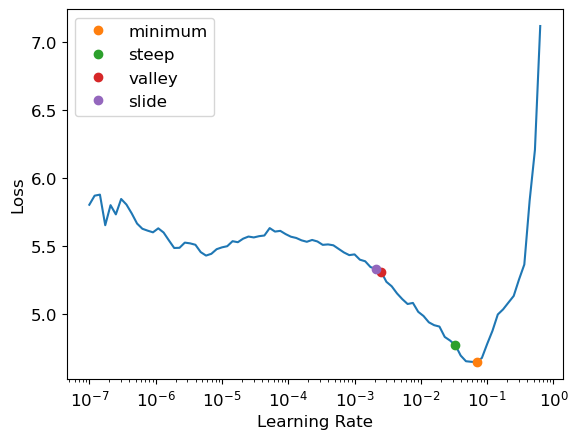

In [20]:
lrs = efnet_3_learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))


In [15]:
print(trainSet.vocab)

['acrochordon', 'actinic_keratosis', 'aimp', 'angiokeratoma', 'angioma', 'angiosarcoma', 'atypical nevus', 'atypical_melanocytic_proliferation', 'basal_cell_carcinoma', 'becker_nevus', 'blue_nevus', 'congenital_nevus', 'dermatofibroma', 'dfsp', 'epidermal_cyst', 'epidermal_nevus', 'hemangioma', 'intraepithelial_carcinoma', 'kaposi_sarcoma', 'keratoacanthoma', 'lentigo_nos', 'lentigo_simplex', 'lichenoid_keratosis', 'lymphangioma', 'malignant_melanoma', 'melanocytic_nevus', 'melanoma', 'melanoma_metastasis', 'milia', 'mucocele', 'mucosal_melanotic_macule', 'neurofibroma', 'nevus', 'organoid_nevus', 'ota_nevus', 'pigmented_benign_keratosis', 'poro_keratosis', 'poroma', 'port_wine_stain', 'pyogenic_granuloma', 'scar', 'sebaceous_hyperplasia', 'seborreic_keratosis', 'skin_tag', 'solar_lentigo', 'spitz_nevus', 'squamous_cell_carcinoma', 'syringoma', 'vascular_lesion', 'venous_lake', 'verruca', 'wart', 'xanthelasma']


In [21]:
print("Valores propuestos: ", lrs)
print("\nValle (Smith Fit One cycle)", lrs[2])

Valores propuestos:  SuggestedLRs(minimum=0.006918309628963471, steep=0.033113110810518265, valley=0.002511886414140463, slide=0.0020892962347716093)

Valle (Smith Fit One cycle) 0.002511886414140463


In [22]:
efnet_3_learner.fine_tune(30, lrs[2], cbs=EarlyStoppingCallback(monitor='valid_loss', patience=5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.547120,1.372070,0.486180,0.513820,06:51


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.355503,1.139241,0.533806,0.466194,07:54
1,1.230010,1.056668,0.554357,0.445643,07:58
2,1.104852,1.015153,0.565043,0.434957,08:01
3,1.116658,0.969301,0.580764,0.419235,07:59
4,1.045888,0.970859,0.586878,0.413122,07:58
5,1.011764,1.069891,0.560625,0.439375,07:01
6,0.889735,0.869741,0.616060,0.383940,06:42
7,0.961826,0.922056,0.606761,0.393239,07:20
8,0.894183,0.806058,0.633118,0.366882,07:20
9,0.869449,0.834746,0.627517,0.372483,06:47


IndexError: index 3 is out of bounds for axis 1 with size 3

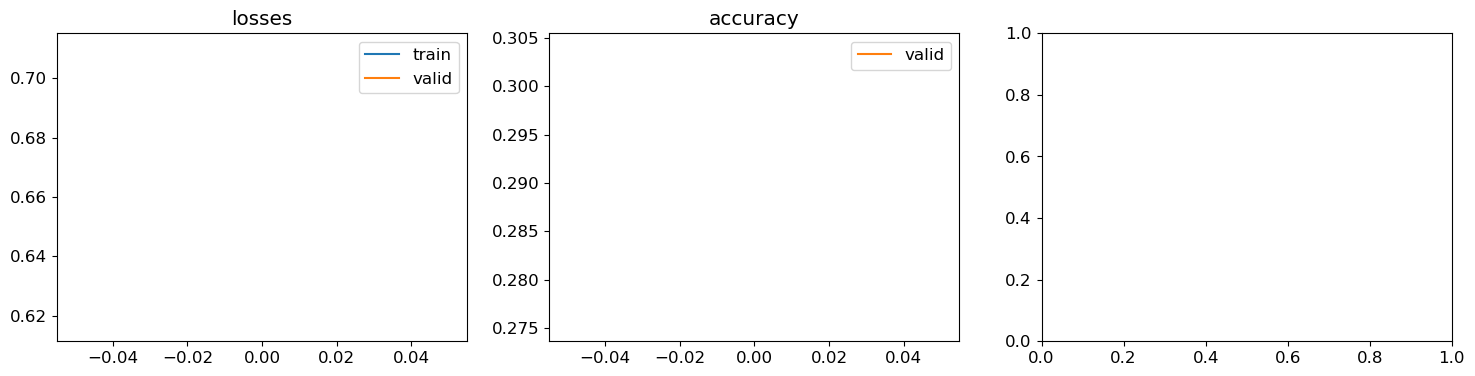

In [28]:
efnet_3_learner.recorder.plot_metrics() # shows accuracy curve along epochs

In [23]:
interp = ClassificationInterpretation.from_learner(efnet_3_learner, 1, trainSet.valid)

preds, targets = efnet_3_learner.get_preds(ds_idx=1)  # ds_idx=1 para el conjunto de validación

y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

In [24]:
balanced_acc = balanced_accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Balanced accuracy: {balanced_acc * 100:.4f}")
print(f"Precision: {prec * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")

Balanced accuracy: 39.4584
Precision: 70.1716
F1 Score: 70.1917


/home/cristhian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.27      0.33      0.30        45
           1       0.56      0.56      0.56       981
           2       0.27      0.12      0.17        24
           3       0.45      0.21      0.29        24
           4       0.60      0.60      0.60        10
           5       0.00      0.00      0.00        12
           6       0.36      0.57      0.44        14
           7       0.00      0.00      0.00        17
           8       0.68      0.67      0.68      1640
           9       0.70      0.58      0.64        12
          10       0.68      0.48      0.56        71
          11       0.19      0.22      0.21        18
          12       0.68      0.70      0.69       780
          13       0.00      0.00      0.00         7
          14       0.73      0.71      0.72       820
          15       1.00      0.08      0.15        24
          16       0.72      0.74      0.73       624
          17       0.60    

/home/cristhian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cristhian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cristhian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Clasificación binaria

In [ ]:
print(df['class'].unique())

In [ ]:
malignant = ['squamous_cell_carcinoma' 'melanoma', 'basal_cell_carcinoma', 'melanoma_metastatis',
             'intraepithelial_carcinoma', 'kaposi_sarcoma', 'angiosarcoma']


def label_func(fname):
    global df
    if (str(fname)[-4:] == ".bmp"):
        el = df.loc[df['image'] == str(fname)[:-4].split("/")[1]]
    else:
        el = df.loc[df['image'] == str(fname).split("/")[1]]

    if (el['class'].values[0]) in malignant:
        return 1
    else:
        return 0

In [ ]:
# División en 70% train y 30% validación

trainSet = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    splitter=RandomSplitter(valid_pct=0.3, seed=0),  # Establecida semilla 0
    get_y=label_func,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(356, method='squish')],  # Redimensionado
    batch_tfms=[Normalize.from_stats(avg,std), *aug_transforms()]
).dataloaders("trainThumbnails/", bs=16)

In [ ]:
efnet_3 = timm.create_model('tf_efficientnet_lite1', pretrained=True)
efnet_3.eval()
efnet_bin_learner = Learner(trainSet, efnet_3, loss_func=FocalLoss(), metrics=[accuracy, error_rate])
efnet_bin_learner.summary()

In [ ]:
lrs = efnet_bin_learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))

print("Valores propuestos: ", lrs)
print("\nValle (Smith Fit One cycle)", lrs[2])

In [ ]:
# Etapa 1: Entrenamiento de la última capa
efnet_bin_learner.freeze()
efnet_bin_learner.fine_tune(1)
# Etapa 2: Descongelar y entrenar
efnet_bin_learner.unfreeze()
efnet_bin_learner.fit_one_cycle(20, lrs[2], cbs=EarlyStoppingCallback(monitor='valid_loss', patience=3), wd=1e-4)

In [ ]:
interp = ClassificationInterpretation.from_learner(efnet_bin_learner, 1, trainSet.valid)

preds, targets = efnet_bin_learner.get_preds(ds_idx=1)  # ds_idx=1 para el conjunto de validación

y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

In [ ]:
report = classification_report(y_true, y_pred)
print(report)

In [ ]:
balanced_acc = balanced_accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Balanced accuracy: {balanced_acc * 100:.4f}")
print(f"Precision: {prec * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")